<a href="https://colab.research.google.com/github/03-hub/ThinkStats2/blob/master/Copy_of_SemEvalTask2_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ncg-task/training-data.git "/content/train"

Cloning into '/content/train'...
remote: Enumerating objects: 6864, done.
remote: Counting objects: 100% (3083/3083), done.
remote: Compressing objects: 100% (2728/2728), done.
remote: Total 6864 (delta 567), reused 2504 (delta 279), pack-reused 3781
Receiving objects: 100% (6864/6864), 157.36 MiB | 38.53 MiB/s, done.
Resolving deltas: 100% (660/660), done.
Checking out files: 100% (3286/3286), done.


IMPORTING REQUIRED LIBRARIES

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import sklearn
import torch
import tensorflow as tf
import random
!pip install transformers
from sklearn.model_selection import train_test_split
from transformers import BertConfig, BertTokenizerFast, TFBertForSequenceClassification
from transformers.file_utils import is_tf_available,is_torch_available,is_torch_tpu_available
from transformers import Trainer,TrainingArguments


     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 64.1 MB/s 
     |████████████████████████████████| 6.6 MB 59.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
def Articlesandcontributions(path):
    articles = []
    contributions = []

    for task_name in os.listdir(path):  #/training-data
        if task_name != 'README.md' and task_name != '.git':
          article_category = os.path.join(path, task_name)  # ./training-data/natural_language_inference

          for folder_name in sorted(os.listdir(article_category)):
              article_index = os.path.join(article_category, folder_name)  # ./datasets/training-data/natural_language_inference/0

              with open(glob.glob(os.path.join(article_index, '*-Stanza-out.txt'))[0], encoding='utf-8') as f:#I used glob to retrieve files with matching pattern
                  article = f.read()                                                                           #* wild card matches the files with stanze out.txt
                  articles.append(article.lower())
                  
              with open(os.path.join(article_index, 'sentences.txt'), encoding='utf-8') as f:
                  contribution = []
                  for line in f.readlines():
                      article_contribution = int(line.strip())
                      contribution.append(article_contribution)
                  contributions.append(contribution) #contribution=[99,10.....]
          #     break
          # break
    return articles, contributions

In [ ]:
def SentenceAndLables(articles, contributions):
    sentences = []
    labels = []
    for i, article in enumerate(articles):
        contribution = contributions[i]

        sents = article.split('\n')[0:-1]
        rand_sents=random.sample(sents,20)
        #random sampling.Choosing 20 random sentences in an article because the input is huge and this device is 
        #not supporting
        for j, sent in enumerate(rand_sents):
            sentences.append(sent)
            if (j + 1) in contribution:
                labels.append(1)
            else:
                labels.append(0)
    return sentences, labels

In [ ]:
train_input_dir='/content/train'

In [ ]:
train_articles, train_contributions = Articlesandcontributions(train_input_dir)

train_sentences, train_labels = SentenceAndLables(train_articles, train_contributions)
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=.2)
#def train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)

#Split arrays or matrices into random train and test subsets.

#list: train_sentences
#(3792 items) ['abstract', 'for instance in the ...', 'sqs is a..]
#list: train_labels
#(3792 items) [0, 1, 0, 0, 0, ...]

#list: val_sentences
#(948 items) ['the importance score...', 'this model encodes a...]
#list: val_labels
#(948 items) [1, 0, 1, 0, 1, ...]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
#def from_pretrained(cls, pretrained_model_name_or_path: Union[str, os.PathLike], *init_inputs, **kwargs)
#Instantiate a [~tokenization_utils_base.PreTrainedTokenizerBase] (or a derived class) from a predefined tokenizer

config = BertConfig.from_pretrained('bert-base-uncased')
#'bert_base-uncased'--Pretrained model on English Language using a Masked Language Modeling
config.num_labels = 2

train_encodings = tokenizer(train_sentences, truncation=True, padding=True)
val_encodings = tokenizer(val_sentences, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

#def from_tensor_slices(tensors, name=None)
#Creates a Dataset whose elements are slices of the given tensors.

print('train data loaded:({0})'.format(len(train_labels)))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
print('validation data loaded:({0})'.format(len(val_labels)))

EPOCHS=3
BATCH_SIZE=8

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-8),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history=model.fit(train_dataset.shuffle(len(train_labels)).batch(BATCH_SIZE),
          validation_data=val_dataset.batch(BATCH_SIZE),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

train data loaded:(3792)
validation data loaded:(948)


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
474/474 [==============================] - 238s 462ms/step - loss: 0.4444 - accuracy: 0.8423 - val_loss: 0.4280 - val_accuracy: 0.8523
Epoch 2/3
474/474 [==============================] - 220s 464ms/step - loss: 0.4366 - accuracy: 0.8431 - val_loss: 0.4191 - val_accuracy: 0.8523
Epoch 3/3
474/474 [==============================] - 220s 465ms/step - loss: 0.4207 - accuracy: 0.8399 - val_loss: 0.4398 - val_accuracy: 0.8523


In [ ]:
!git clone https://github.com/ncg-task/test-data.git "/content/test"

Cloning into '/content/test'...
remote: Enumerating objects: 2508, done.
remote: Total 2508 (delta 0), reused 0 (delta 0), pack-reused 2508
Receiving objects: 100% (2508/2508), 215.28 MiB | 42.97 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (2060/2060), done.


FUNCTIONS TO EXTRACT SENTENCES FROM ARTICLES AND CLASSIFYING THEM.

In [ ]:
def Articlesandcontributions2(data_dir):
    articles = []
    contributions = []

    for category in os.listdir(data_dir):
        if category != 'README.md' and category != '.git' and category != 'submission.zip':
          article_category = os.path.join(data_dir, category)
          # print(article_category)

          for foldname in sorted(os.listdir(article_category)):
              article_index = os.path.join(article_category, foldname)

              # print(glob.glob(os.path.join(article_index, '*-Stanza-out.txt')))
              # if len(glob.glob(os.path.join(article_index, '*-Stanza-out.txt'))) != 0:
              with open(glob.glob(os.path.join(article_index, '*-Stanza-out.txt'))[0], encoding='utf-8') as f:
                  article = f.read()
                  articles.append(article.lower())

              with open(os.path.join(article_index, 'sentences.txt'), encoding='utf-8') as f:
                  contribution = []
                  for line in f.readlines():
                      article_contribution = int(line.strip())
                      contribution.append(article_contribution)
                  contributions.append(contribution)
              # break
          # break
    return articles, contributions


def SentenceAndLables2(articles, contributions):
    sentences = []
    labels = []
    for i, article in enumerate(articles):
        contribution = contributions[i]

        sents = article.split('\n')[0:-1]
        # sents = article.split('\n')
        rand_sents=random.sample(sents,10)
        for row, sent in enumerate(rand_sents):
            sentences.append(sent)
            
            if (row + 1) in contribution:
                labels.append(1)
            else:
                labels.append(0)
    # print(sentences)
    # print(labels)
    return sentences, labels

In [ ]:
test_input_dir='/content/test'

In [ ]:
test_articles, test_contributions = Articlesandcontributions2(test_input_dir)

test_sentences, test_labels = SentenceAndLables2(test_articles, test_contributions)


PREPROCESSING TEST DATA

In [ ]:
test_encodings = tokenizer(test_sentences, truncation=True, padding=True)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))
print('test data loaded:({0})'.format(len(test_labels)))

test data loaded:(1550)


EVALUATING PERFORMENCE

1550/1550 [==============================] - 55s 34ms/step - loss: 0.4990 - accuracy: 0.8265
test loss: 0.49901753664016724
test accuracy: 0.8264515995979309


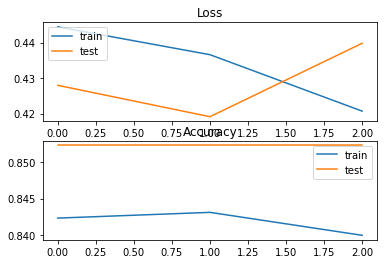

In [ ]:

BATCH_SIZE=1
test_loss,test_accuracy= model.evaluate(test_dataset.batch(BATCH_SIZE), batch_size=BATCH_SIZE)
print('test loss:', test_loss)
print('test accuracy:', test_accuracy)

#plot loss 
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')

plt.plot
plt.legend()

#plot accuracy 
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')

plt.legend()
plt.show()



In [ ]:

import numpy as np

y_probs=model.predict(test_dataset.batch(BATCH_SIZE), batch_size=BATCH_SIZE)
result = np.argmax(y_probs[0], axis=-1)

print(y_probs)
print(y_probs[0])
print(y_probs[0].shape)
print(type(y_probs[0]))

print(result)
print(len(result))
print(type(result))

test_labels=np.array(test_labels)
print(len(test_labels))
print(type(test_labels))
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score

accuracy=accuracy_score(test_labels,result)
print('accuracy: %f' % accuracy)

#Compute precision, recall, F-measure and support for each class.

#The precision is the ratio tp / (tp + fp) where tp is the number of
#true positives and fp the number of false positives. The precision is

cm=confusion_matrix(test_labels,result)
print(cm)

TFSequenceClassifierOutput(loss=None, logits=array([[ 1.3844751 , -1.0349725 ],
       [ 1.5504762 , -1.0045817 ],
       [ 1.3055753 , -0.9613407 ],
       ...,
       [ 1.4532176 , -1.0905312 ],
       [ 1.3246338 , -0.83081895],
       [ 1.4067885 , -0.9734804 ]], dtype=float32), hidden_states=None, attentions=None)
[[ 1.3844751  -1.0349725 ]
 [ 1.5504762  -1.0045817 ]
 [ 1.3055753  -0.9613407 ]
 ...
 [ 1.4532176  -1.0905312 ]
 [ 1.3246338  -0.83081895]
 [ 1.4067885  -0.9734804 ]]
(1550, 2)
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
1550
<class 'numpy.ndarray'>
1550
<class 'numpy.ndarray'>
accuracy: 0.826452
[[1281    0]
 [ 269    0]]


In [ ]:
result = np.argmax(y_probs[0], axis=1)
print(y_probs)
print(y_probs[0])
print(y_probs[0].shape)
print(type(y_probs[0]))

print(result)
print(len(result))
print(type(result))
set(test_labels)-set(result)
from sklearn.metrics import classification_report
print(classification_report(test_labels,result))

TFSequenceClassifierOutput(loss=None, logits=array([[ 1.3844751 , -1.0349725 ],
       [ 1.5504762 , -1.0045817 ],
       [ 1.3055753 , -0.9613407 ],
       ...,
       [ 1.4532176 , -1.0905312 ],
       [ 1.3246338 , -0.83081895],
       [ 1.4067885 , -0.9734804 ]], dtype=float32), hidden_states=None, attentions=None)
[[ 1.3844751  -1.0349725 ]
 [ 1.5504762  -1.0045817 ]
 [ 1.3055753  -0.9613407 ]
 ...
 [ 1.4532176  -1.0905312 ]
 [ 1.3246338  -0.83081895]
 [ 1.4067885  -0.9734804 ]]
(1550, 2)
<class 'numpy.ndarray'>
[0 0 0 ... 0 0 0]
1550
<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1281
           1       0.00      0.00      0.00       269

    accuracy                           0.83      1550
   macro avg       0.41      0.50      0.45      1550
weighted avg       0.68      0.83      0.75      1550



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
